In [6]:

# Step 1: Import Libraries
import pandas as pd
import numpy as np
import pickle
import json
import logging
import dagshub
import mlflow
import mlflow.keras 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt



In [7]:

# Step 2: Configure Logging and MLflow
# This connects your script to your DagsHub project's MLflow server
dagshub.init(repo_owner='Mayankvlog', repo_name='Movies_recommedation_data-science-project', mlflow=True)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
mlflow.set_experiment("Movie Recommendation System")

# Step 3: Load and Preprocess Data
logging.info("Loading dataset...")
movies_df = pd.read_csv('data/tmdb_5000_movies.csv')

def extract_names(json_str):
    try:
        if pd.isna(json_str): return []
        items = json.loads(json_str)
        return [item['name'] for item in items]
    except (json.JSONDecodeError, TypeError):
        return []

logging.info("Preprocessing data...")
movies_df['genres'] = movies_df['genres'].apply(extract_names)

def create_soup(x):
    return ' '.join(x['genres'])

movies_df['soup'] = movies_df.apply(create_soup, axis=1)
logging.info("Data preprocessing complete.")



2025-10-15 09:45:07,297 - INFO - HTTP Request: GET https://dagshub.com/api/v1/repos/Mayankvlog/Movies_recommedation_data-science-project "HTTP/1.1 200 OK"


Initialized MLflow to track repo "Mayankvlog/Movies_recommedation_data-science-project"

2025-10-15 09:45:07,309 - INFO - Initialized MLflow to track repo "Mayankvlog/Movies_recommedation_data-science-project"


Repository Mayankvlog/Movies_recommedation_data-science-project initialized!

2025-10-15 09:45:07,312 - INFO - Repository Mayankvlog/Movies_recommedation_data-science-project initialized!
2025-10-15 09:45:07,639 - INFO - Loading dataset...
2025-10-15 09:45:07,679 - INFO - Preprocessing data...
2025-10-15 09:45:07,897 - INFO - Data preprocessing complete.


In [8]:

# Step 4: Feature Engineering with TF-IDF
logging.info("Vectorizing text data...")
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = tfidf.fit_transform(movies_df['soup'])

X = tfidf_matrix.toarray()
y = X

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Build the Neural Network Model
logging.info("Building the model...")
input_dim = X_train.shape[1]

encoder = Sequential([
    Dense(512, activation='relu', input_shape=(input_dim,)),
    Dense(256, activation='tanh'),
    Dense(128, activation='elu'),
    Dense(64, activation='selu'),
    Dense(32, activation='sigmoid', name='embedding_layer')
], name="Encoder")

autoencoder = Sequential([
    encoder,
    Dense(64, activation='selu'),
    Dense(128, activation='elu'),
    Dense(256, activation='tanh'),
    Dense(512, activation='relu'),
    Dense(input_dim, activation='softmax')
], name="Autoencoder")

# Step 6: Compile the Model
logging.info("Compiling the model...")
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
autoencoder.summary()



2025-10-15 09:45:07,940 - INFO - Vectorizing text data...
2025-10-15 09:45:08,066 - INFO - Building the model...
C:\Users\mayan\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-15 09:45:08,405 - INFO - Compiling the model...


Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Encoder (Sequential)                 │ (None, 32)                  │         186,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 22)                  │          11,286 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 372,662 (1.42 MB)

 Trainable params: 372,662 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

2025-10-15 09:45:08,474 - INFO - Starting model training...


Epoch 1/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 0.0289 - val_loss: 0.0144
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0126 - val_loss: 0.0107
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0096 - val_loss: 0.0095
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 5/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 6/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 7/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0073 - val_loss: 0.0080
Epoch 8/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0074 - val_loss: 0.0075
Epoch 9/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0071 - val_loss: 0.0075
Epoch 10/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0072 - val_loss: 0.0074
Epoch 11/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 12/50
121/121 ━━━━━━━━━━━━━━━━━━━━

2025-10-15 09:48:27,626 - INFO - Logging metrics to MLflow...
2025/10/15 09:49:58 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025-10-15 09:50:59,335 - INFO - Model training complete.


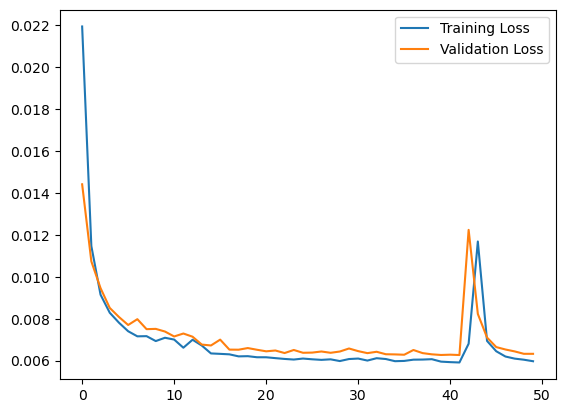

In [9]:

# Step 7: Train the Model with MLflow Logging
logging.info("Starting model training...")
with mlflow.start_run() as run:
    mlflow.log_param("epochs", 50)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("tfidf_features", 1000)

    history = autoencoder.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=1
    )

    logging.info("Logging metrics to MLflow...")
    for epoch in range(len(history.history['loss'])):
        mlflow.log_metric("train_loss", history.history['loss'][epoch], step=epoch)
        mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)

    # Log the encoder model using the now-imported mlflow.keras module
    mlflow.keras.log_model(encoder, "encoder_model")

    # Plot and log training history
    fig, ax = plt.subplots()
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.legend()
    plt.savefig("training_loss.png")
    mlflow.log_artifact("training_loss.png")

logging.info("Model training complete.")


In [10]:

# Step 8: Save Model and Supporting Files
logging.info("Saving project artifacts...")
encoder.save('model/movie_recommender.h5')
with open('model/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
with open('model/movies_df.pkl', 'wb') as f:
    pickle.dump(movies_df, f)

logging.info("All files saved successfully.")


2025-10-15 09:50:59,706 - INFO - Saving project artifacts...
2025-10-15 09:50:59,708 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-10-15 09:50:59,888 - INFO - All files saved successfully.
